In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

#these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {'MD': {}}

pop_total_denominator = 330759736
nDistricts = 435
target = pop_total_denominator / nDistricts


g = 0
scale = 8
map_buffer_ratio = .1
theproj = 3857 #{'init': 'epsg:9822'}
equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
desired_pct_area_overlap = 0.01

show_water = True
show_roads = False
water_area_tol = 1 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('state_name')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('state').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state in these_states_dict.keys():
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['stusab'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['stusab'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
#print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))


looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!
Got old and new numbers of districts for 1 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


In [8]:
# print('getting states...')
# state_all_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
# state_all_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_all_gdf['STATEFP'], errors='coerce')
# #state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
# #state_all_gdf[~state_all_gdf['STUSPS'].isin(['DC', 'PR', 'MP', 'VI', 'AS', 'GU'])][['STATEFP', 'STUSPS', 'NAME']].sort_values(by='STUSPS')
# state_all_gdf.columns


# Read redistricting geo data

In [9]:
s = time.time()
print('reading redistricting geography data for focus states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
geo_df.set_index('SUMLEV')
print('adding summary level descriptions...')
geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for focus states...
	reading mdgeo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97
adding summary level descriptions...


Read 144,718 geographies in 0 minutes 7 seconds!


In [10]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.1 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for MD...
		24 CRS = epsg:4269


Joined 1,475 tracts to shapefiles in 10.7 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


adding shapefiles...


Joined 8 congressional districts to shapefiles in 2.7 seconds!


In [14]:
s = time.time()


state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')

if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()
    #state_numbers_include_list = list(set([pandas.to_numeric(x[89:91], errors='coerce') for x in waterfiles]))
    #[x for x in waterfiles if ()]
    #possible_state_list = state_codes_df[state_codes_df['STATE'] <= 56]['STATE'].tolist()
    for i in range(0, len(waterfiles)):
        if (np.mod(i, 50) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
roads_gdf = geopandas.GeoDataFrame()
roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
for i in range(0, len(roads_file_list)):
    if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
        print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
    roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
    roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
roads_gdf = roads_gdf.set_index('LINEARID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
#print('\n')


print('Done!')



getting states...
getting counties...
Got 1 states and 24 counties in 6.5 seconds!


getting water areas...
	reading water file 0 of 24...
Got 301 water areas in 0 minutes 10.9 seconds!


getting CBSAs (metro areas)...
Got 939 CBSAs in 2.2 seconds!


getting places...
	reading place file 0 of 1...
Got 536 places in 0.3 seconds!


getting roads...
	Reading road file 1 of 24...
	Reading road file 11 of 24...
	Reading road file 21 of 24...
	Reading road file 24 of 24...
Got 262,268 roads in 0 minutes 34.2 seconds!
Done!


ploting congressional districts...
Plotting district 1...
Plotting district 2...
Plotting district 3...
Plotting district 4...
Plotting district 5...
Plotting district 6...
Plotting district 7...
Plotting district 8...
ploting census tracts...
ploting water areas...


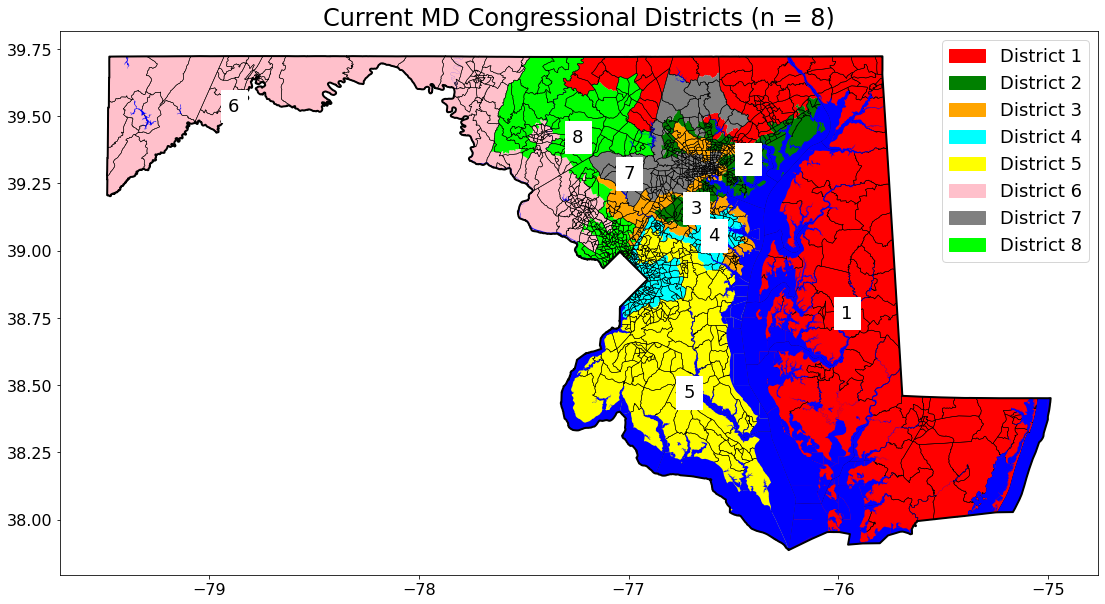

In [15]:
xlimits = cd_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
ylimits = cd_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]
aspect_ratio = xspan / yspan

xbuffer = xspan * map_buffer_ratio
ybuffer = yspan * map_buffer_ratio

xlimits = cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
ylimits = cd_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]

fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
ax.set_aspect('equal')
#thedistricts = [x for x in cd_gdf['CD116'].drop_duplicates().tolist()]

thedistricts = list(set([int(x) for x in cd_gdf['CD116'].drop_duplicates().tolist()]))

legend_list = []

print('ploting congressional districts...')
for thiscd in thedistricts:
    print('Plotting district {0:.0f}...'.format(thiscd))
    #cd_gdf[cd_gdf['CD116'] == thiscd].to_crs(epsg=theproj).plot(ax=ax, color=district_color_cycle[thiscd])
    cd_gdf[cd_gdf['CD116'] == thiscd].plot(ax=ax, color=district_color_cycle[thiscd])
    legend_list.append(mpatches.Patch(color=district_color_cycle[thiscd], label='District {0:,.0f}'.format(thiscd)))
    
    annotator = thiscd #parse_road_name(thisrow['FULLNAME'])
    centerpoint = (cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLON'].values[0], cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLAT'].values[0])
    ax.annotate(annotator, centerpoint, 
                color='black', backgroundcolor='white', ha='center', va='center', fontsize=2.25*scale)
    
print('ploting census tracts...')
tract_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.0625*scale)

if (show_water):
    print('ploting water areas...')
    water_gdf.plot(ax=ax, color='blue')
    
#state_gdf.to_crs(epsg=theproj).plot(ax=ax, color='none', edgecolor='black', lw=0.25*scale)
state_gdf.plot(ax=ax, color='none', edgecolor='black', lw=0.25*scale)
    
ax.legend(handles=legend_list, fontsize=2.25*scale)

if (len(list(these_states_dict.keys())) == 1):
    plt.title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=3*scale)
else:
    plt.title('Current Congressional Districts', fontsize=3*scale)

plt.xticks(fontsize=2*scale)
plt.yticks(fontsize=2*scale)

plt.show()

# #fig.get_size_inches()
#cd_gdf[cd_gdf['CD116'] == 'ZZ']




In [16]:
#for i in range(1,)
#cd_gdf[cd_gdf['CD116'] == 1]

state_districts_average = cd_gdf['POP100'].sum() / len(cd_gdf)
state_target = state_districts_average
for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1):
    print('District {0:} (pop = {1:,.0f} ({2:.1%} of target, overshoot = {3:,.0f}))'.format(cd_gdf[cd_gdf['CD116'] == i]['BASENAME'].values[0], cd_gdf[cd_gdf['CD116'] == i]['POP100'].sum(), cd_gdf[cd_gdf['CD116'] == i]['POP100'].sum() / state_districts_average, cd_gdf[cd_gdf['CD116'] == i]['POP100'].sum() - state_districts_average))



    

District 1 (pop = 743,611 (96.3% of target, overshoot = -28,542))
District 2 (pop = 785,331 (101.7% of target, overshoot = 13,178))
District 3 (pop = 774,165 (100.3% of target, overshoot = 2,012))
District 4 (pop = 798,925 (103.5% of target, overshoot = 26,772))
District 5 (pop = 795,379 (103.0% of target, overshoot = 23,226))
District 6 (pop = 791,619 (102.5% of target, overshoot = 19,466))
District 7 (pop = 703,752 (91.1% of target, overshoot = -68,401))
District 8 (pop = 784,442 (101.6% of target, overshoot = 12,289))


In [127]:
tract_gdf.loc[:, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[
    ['Allegany County',6],
    ['Anne Arundel County',4],
    ['Baltimore County',2],
    ['Baltimore city',7],
    ['Calvert County',5],
    ['Caroline County',1],
    ['Carroll County',3],
    ['Cecil County',1],
    ['Charles County',5],
    ['Dorchester County',1],
    ['Frederick County',6],
    ['Garrett County',6],
    ['Harford County',1],
    ['Howard County',3],
    ['Kent County',1],
    ['Montgomery County',8],
    ["Prince George's County",4],
    ["Queen Anne's County",1],
    ['Somerset County',1],
    ["St. Mary's County",5],
    ['Talbot County',1],
    ['Washington County',6],
    ['Wicomico County',1],
    ['Worcester County',1]
], columns=['COUNTY_NAME', 'new_district_by_county'])

place_mapper_df = pandas.DataFrame(data=[
    ['Towson',7],
    ['Pikesville',7],
    ['Parkville',7],
    ['Baltimore Highlands',7],
    ['Arbutus',7],
    ['Lansdowne',7],
    ['Brooklyn Park',7],
    ['Damascus',6],
    ['Germantown',6],
    ['Clarksburg',6],
    ['Gaithersburg',6],
    ['Laurel',3],
    ['West Laurel',3],
    ['South Laurel',3],
    ['Maryland City',3], 
    ['Ilchester',2],
    ['Elkridge',2],
    ['Linthicum',2], 
    ['Ferndale',2],
    ['Glen Burnie',2],
    ['Jessup',3],
    ['Cloverly',3],
    ['Colesville',3],
    ['Bladensburg',4],
    ['Hyattsville',4]
], columns=['NAME', 'new_district_by_place'])

tract_gdf.loc[:, 'new_district'] = tract_df.reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']


tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Baltimore County') & (tract_gdf['INTPTLAT'] >= 39.525), 'new_district'] = 1
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Montgomery County') & (tract_gdf['INTPTLON'] <= -77.225), 'new_district'] = 6
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Montgomery County') & ((tract_gdf['INTPTLON'] >= -77.225) & (tract_gdf['INTPTLAT'] >= 39.125)), 'new_district'] = 3
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == "Prince George's County") & (tract_gdf['INTPTLAT'] <= 38.9), 'new_district'] = 5
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == "Prince George's County") & ((tract_gdf['INTPTLAT'] >= 38.9) & (tract_gdf['INTPTLON'] <= -76.92)), 'new_district'] = 8
#tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Anne Arundel County') & (tract_gdf['INTPTLAT'] >= 39.125), 'new_district'] = 2

place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))
for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    #tract_gdf.loc[(tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist()))), 'new_district'] = i
    tract_gdf.loc[(tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist()))), 'new_district'] = i

    
tract_gdf.loc[['1400000US24005490400', '1400000US24003750201', '1400000US24003750300'], 'new_district'] = 7

tract_gdf.loc[['1400000US24005408200'], 'new_district'] = 1    # N Baltimore County
tract_gdf.loc[['1400000US24005404600'], 'new_district'] = 3   # N Baltimore County
tract_gdf.loc[['1400000US24005410200', '1400000US24005411201'], 'new_district'] = 1  # N Baltimore County
tract_gdf.loc[['1400000US24005402201', '1400000US24005404800', '1400000US24005402202', '1400000US24027602700'], 'new_district'] = 3 # W Baltimore County
tract_gdf.loc[['1400000US24005411101', '1400000US24005411102', '1400000US24005411202', '1400000US24005451702', '1400000US24005451801', '1400000US24005411302'], 'new_district'] = 1 # NE Baltimore County



tract_gdf.loc[['1400000US24003750900', '1400000US24003751200', '1400000US24003980000'], 'new_district'] = 2  # Glen Burnie / BWI
tract_gdf.loc[['1400000US24027601104', '1400000US24027601203', '1400000US24027602700'], 'new_district'] = 2  # Elkridge / Ilchester

tract_gdf.loc[['1400000US24031701409', '1400000US24031701414', '1400000US24031701415', '1400000US24031701417', '1400000US24031701418', '1400000US24031701422', '1400000US24031701423'], 'new_district'] = 3  # near Laurel
tract_gdf.loc[['1400000US24031701426', '1400000US24031701427', '1400000US24033800105', '1400000US24033800106', '1400000US24033800203', '1400000US24033800212', '1400000US24033800213', '1400000US24033807407', '1400000US24031701424'], 'new_district'] = 3  # near Laurel


tract_gdf.loc[['1400000US24031700204', '1400000US24031700209', '1400000US24031700315', '1400000US24031700724', '1400000US24031700829', '1400000US24031700836', '1400000US24031700733', '1400000US24031700810', '1400000US24031700813'], 'new_district'] = 6


tract_gdf.loc[['1400000US24031700723', '1400000US24031700724', '1400000US24031700725', '1400000US24031700726', '1400000US24031700727', '1400000US24031700731'], 'new_district'] = 8


tract_gdf.loc[['1400000US24003740106', '1400000US24003751500'], 'new_district'] = 3  #  NW Anne Arundel County
tract_gdf.loc[['1400000US24003740603'], 'new_district'] = 3  #  W Anne Arundel County
tract_gdf.loc[['1400000US24033807408', '1400000US24033800410', '1400000US24033800411'], 'new_district'] = 3  #  W Anne Arundel County


tract_gdf.loc[['1400000US24033806900', '1400000US24033807404'], 'new_district'] = 8  #  N of College Park
    
tract_gdf.loc[['1400000US24033803900', '1400000US24033804002', '1400000US24033804300', '1400000US24033804400'], 'new_district'] = 4  #  Bladensburg /  Hyattsville
tract_gdf.loc[['1400000US24033804600', '1400000US24033804700', '1400000US24033804801', '1400000US24033804802'], 'new_district'] = 4  #  Bladensburg /  Hyattsville
tract_gdf.loc[['1400000US24033806501', '1400000US24033807102', '1400000US24033807500'], 'new_district'] = 4  #  Bladensburg /  Hyattsville

# for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     print(place_mapper_df[place_mapper_df['new_district_by_place'] == i])
#place_mapper_df

#place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME').set_index('GEOID').geometry


#tract_gdf[tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == 7].geometry.tolist()))]['new_district']
#tract_gdf.groupby('new_district')['POP100'].sum()
#fig, ax = plt.subplots(1,1)
#tract_gdf.plot(ax=ax, color='none', edgecolor='black')

print('\n')
for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))




District 1: n = 780,805 (101.1% of target; overshot = 8,652)
District 2: n = 778,869 (100.9% of target; overshot = 6,716)
District 3: n = 768,258 (99.5% of target; overshot = -3,895)
District 4: n = 766,340 (99.2% of target; overshot = -5,813)
District 5: n = 777,949 (100.8% of target; overshot = 5,796)
District 6: n = 763,879 (98.9% of target; overshot = -8,274)
District 7: n = 766,426 (99.3% of target; overshot = -5,727)
District 8: n = 774,698 (100.3% of target; overshot = 2,545)


xspan = 4.50 degrees
aspect_ratio  = 2.45:1


plotting tracts...
	base layer...


/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


plotting water areas...


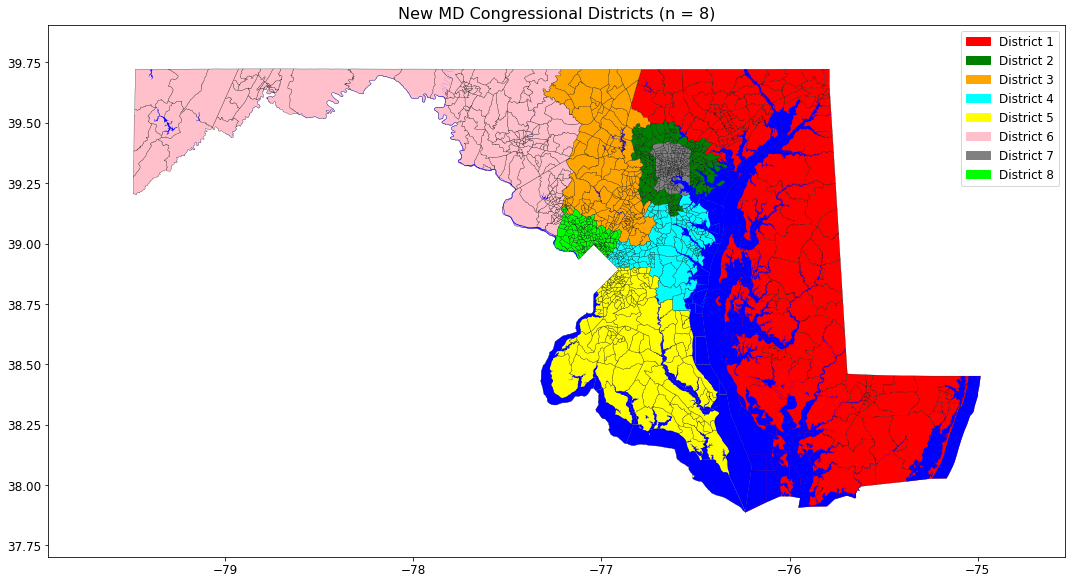



District 1: n = 780,805 (101.1% of target; overshot = 8,652)
District 2: n = 778,869 (100.9% of target; overshot = 6,716)
District 3: n = 768,258 (99.5% of target; overshot = -3,895)
District 4: n = 766,340 (99.2% of target; overshot = -5,813)
District 5: n = 777,949 (100.8% of target; overshot = 5,796)
District 6: n = 763,879 (98.9% of target; overshot = -8,274)
District 7: n = 766,426 (99.3% of target; overshot = -5,727)
District 8: n = 774,698 (100.3% of target; overshot = 2,545)


In [131]:
show_water = True
show_roads = False
label_tracts = False
label_places = False

the_label_size = 12
the_annotation_size = 12
the_line_width = .25
the_line_width_wide = 4
the_legend_size = 12
the_title_size = 16

maybe_other_tracts = []

places_to_show = []
#places_to_show += maybe_other_places

place_color = 'green'

bounds_counties = ["Prince George's"]

xlimits = state_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
ylimits = state_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xlimits = [unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[0], unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[2]]
# ylimits = [unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[1], unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[3]]


# # # Prince George's DC suburbs
# xlimits = [-77.03,-76.83]
# ylimits = [38.9,39.13]

xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]
aspect_ratio = xspan / yspan

xbuffer = xspan * map_buffer_ratio
ybuffer = yspan * map_buffer_ratio

xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

print('xspan = {0:,.2f} degrees'.format(xspan))
print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
print('\n')

# fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
ax.set_aspect('equal')

# print('plotting CBSAs...')
# cbsa_gdf[
#     ((cbsa_gdf['INTPTLON'] >= xlimits[0]) & (cbsa_gdf['INTPTLON'] <= xlimits[1]))
#     & ((cbsa_gdf['INTPTLAT'] >= ylimits[0]) & (cbsa_gdf['INTPTLAT'] <= ylimits[1]))
# ].plot(ax=ax, color='none', edgecolor='yellow')


print('plotting tracts...')

# base layer
print('\tbase layer...')
legend_list = []
for i in range(1,9):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        #print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
        tract_gdf[(tract_gdf['new_district'] == i)].plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)        
        legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

        
if (len(maybe_other_tracts) > 0):
#    tract_gdf[(tract_gdf['new_district'].isnull()) & (tract_gdf['census_tract'].apply(lambda x: x not in maybe_other_tracts))].plot(ax=ax, color='none', edgecolor='black', lw=the_line_width)
    tract_gdf[(tract_gdf['census_tract'].apply(lambda x: x not in maybe_other_tracts))].plot(ax=ax, color='none', edgecolor='black', lw=the_line_width)
    tract_gdf[(tract_gdf['census_tract'].isin(maybe_other_tracts))].plot(ax=ax, color='none', edgecolor='orange', lw=the_line_width_wide, linestyle='solid')
else:
    tract_gdf[(tract_gdf['new_district'].isnull())].plot(ax=ax, color='none', edgecolor='gray', lw=the_line_width)


if (label_tracts):
    print('labeling tracts...')
    if (len(maybe_other_tracts) > 0):
        print('maybe', len(maybe_other_tracts))
        for ix, thisrow in tract_gdf[
            ((tract_gdf['INTPTLON'] >= xlimits[0]) & (tract_gdf['INTPTLON'] <= xlimits[1])) & ((tract_gdf['INTPTLAT'] >= ylimits[0]) & (tract_gdf['INTPTLAT'] <= ylimits[1]))
            & (tract_gdf['census_tract'].isin(maybe_other_tracts))
        ].sort_values(by='census_tract').iterrows():
            print('census tract {0:}: ix = {1:}'.format(thisrow['census_tract'], ix))
            annotator = '{0:}\n{1:,.0f}'.format(thisrow['census_tract'], geo_df.loc[ix]['POP100'])
            centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
            ax.annotate(annotator, centerpoint, 
                        color='black', backgroundcolor='white', ha='center', va='center', 
                        fontsize=the_annotation_size)
    else:
        for ix, thisrow in tract_gdf[
            (((tract_gdf['INTPTLON'] >= xlimits[0]) & (tract_gdf['INTPTLON'] <= xlimits[1])) & ((tract_gdf['INTPTLAT'] >= ylimits[0]) & (tract_gdf['INTPTLAT'] <= ylimits[1])))
#            & (tract_gdf['new_district'].isnull())
#            & (tract_gdf['new_district'] == 8)
#            & (tract_gdf['INTPTLAT'] >= 39.05)
#             & (
#                 ((tract_gdf['INTPTLAT'] >= 39.37) & (tract_gdf['new_district'] == 2))
#                 | ((tract_gdf['INTPTLON'] <=  -76.64) & (tract_gdf['new_district'] == 1))
#               )
        ].sort_values(by='census_tract').iterrows():
            print('{0:}:\t{1:}'.format(thisrow['census_tract'], ix))
            annotator = '{0:}\n{1:,.0f}'.format(thisrow['census_tract'], geo_df.loc[ix]['POP100'])
            centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
            ax.annotate(annotator, centerpoint, 
                        color='gray', backgroundcolor='white', ha='center', va='center', 
                        fontsize=the_annotation_size)


# print('plotting places...')
# if (len(places_to_show) > 0):
#     place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
#         & (place_gdf['NAME'].isin(places_to_show))
#     ].plot(ax=ax, edgecolor='red', lw=the_line_width_wide, color='none', linestyle='solid')
# else:
#     place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
#     ].plot(ax=ax, edgecolor='red', lw=the_line_width_wide, color='none')
# if (label_places):
#     if (len(places_to_show) > 0):
#         print('\tlabeing chosen places...')
#         for ix, thisrow in place_gdf[
#             ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
#             & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
#             & (place_gdf['NAME'].isin(places_to_show))
#         ].iterrows():
#             annotator = '{0:}\n{1:,.0f}'.format(thisrow['NAME'].replace('-','-\n').replace(' ','\n').upper(), geo_df.loc[ix]['POP100'])
#             centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#             ax.annotate(annotator, centerpoint, 
#                         color='red', backgroundcolor='white', ha='center', va='center', 
#                         fontsize=the_annotation_size)
#     else:
#         print('\tlabeing all places on map...')
#         for ix, thisrow in place_gdf[
#             ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
#             & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
#         ].iterrows():
#             annotator = '{0:}\n{1:,.0f}'.format(thisrow['NAME'].replace('-','-\n').replace(' ','\n').upper(), geo_df.loc[ix]['POP100'])
#             centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#             ax.annotate(annotator, centerpoint, 
#                         color='red', backgroundcolor='white', ha='center', va='center', 
#                         fontsize=the_annotation_size)

if (show_water):
    print('plotting water areas...')
    water_gdf.plot(ax=ax, color='blue')

    
if (show_roads):
    print('plotting roads...')
    print('\tsmall...')
    roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color='black', linewidth=0.1)
    print('\tlarge...')
    roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=0.25) 
    roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=0.5) 
    roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=0.75)     
    roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=1) 
plt.xlim(xlimits)
plt.ylim(ylimits)

plt.xticks(fontsize=the_label_size)
plt.yticks(fontsize=the_label_size)

ax.legend(handles=legend_list, fontsize=the_legend_size)

if (len(list(these_states_dict.keys())) == 1):
    plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
    ), fontsize=the_title_size)
else:    
    plt.title('New Congressional Districts', fontsize=the_title_size)


plt.show()
print('\n')
for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

#  

In [136]:

new_district_shapes_gdf

merging tract shapes get district 1 boundaries...
merging tract shapes get district 2 boundaries...
merging tract shapes get district 3 boundaries...
merging tract shapes get district 4 boundaries...
merging tract shapes get district 5 boundaries...
merging tract shapes get district 6 boundaries...
merging tract shapes get district 7 boundaries...
merging tract shapes get district 8 boundaries...


,new_district,geometry
0,1,"POLYGON ((-75.54195 38.00136, -75.54323 38.001..."
1,2,"POLYGON ((-76.58975 39.12155, -76.58980 39.121..."
2,3,"POLYGON ((-76.75126 39.03471, -76.75085 39.034..."
3,4,"POLYGON ((-76.62308 38.76189, -76.62308 38.761..."
4,5,"POLYGON ((-76.32191 38.32728, -76.31960 38.317..."
5,6,"POLYGON ((-77.21329 39.10018, -77.21317 39.100..."
6,7,"POLYGON ((-76.52969 39.21731, -76.52967 39.217..."
7,8,"MULTIPOLYGON (((-76.96704 38.95132, -76.96710 ..."


merging tract shapes get district 1 boundaries...
merging tract shapes get district 2 boundaries...
merging tract shapes get district 3 boundaries...
merging tract shapes get district 4 boundaries...
merging tract shapes get district 5 boundaries...
merging tract shapes get district 6 boundaries...
merging tract shapes get district 7 boundaries...
merging tract shapes get district 8 boundaries...
ploting congressional districts...
Plotting district 1...
Plotting district 2...
Plotting district 3...
Plotting district 4...
Plotting district 5...
Plotting district 6...
Plotting district 7...
Plotting district 8...
ploting census tracts...
ploting water areas...


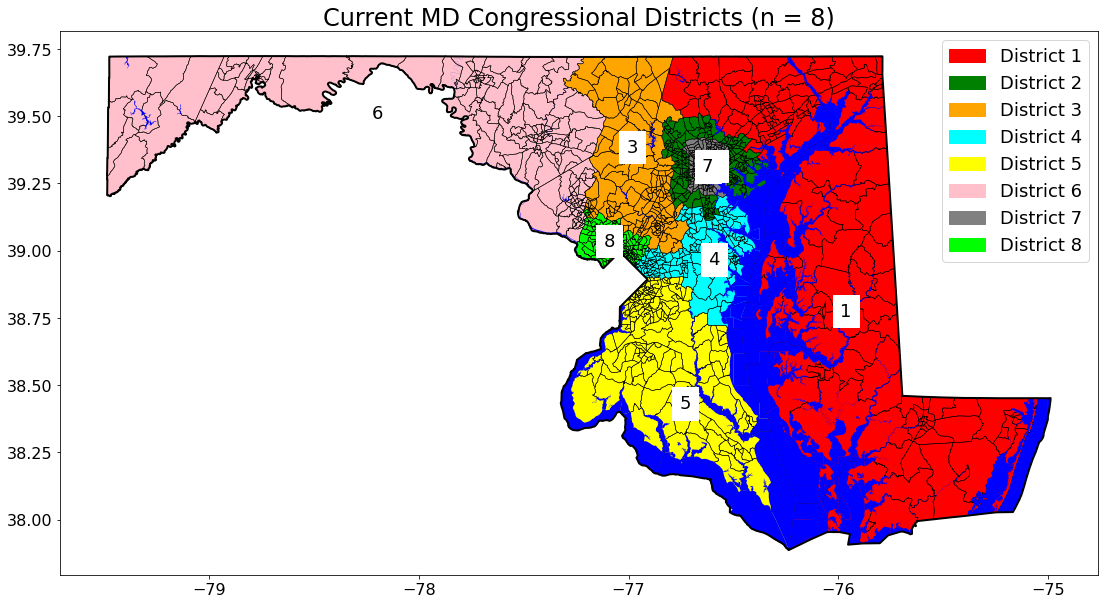

In [143]:
new_district_shapes_gdf = geopandas.GeoDataFrame(data=None, columns=['new_district', 'geometry'], crs=tract_gdf.crs, geometry='geometry').set_index('new_district')
for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    print('merging tract shapes get district {0:,.0f} boundaries...'.format(i))
    new_district_shapes_gdf.loc[i, 'geometry'] = unary_union(tract_gdf[tract_gdf['new_district'] == i].geometry.tolist())    
#new_district_shapes_gdf = new_district_shapes_gdf.reset_index()
    
xlimits = cd_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
ylimits = cd_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]
aspect_ratio = xspan / yspan

xbuffer = xspan * map_buffer_ratio
ybuffer = yspan * map_buffer_ratio

xlimits = cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
ylimits = cd_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]

fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
ax.set_aspect('equal')
#thedistricts = [x for x in cd_gdf['CD116'].drop_duplicates().tolist()]

thedistricts = list(set([int(x) for x in cd_gdf['CD116'].drop_duplicates().tolist()]))

legend_list = []

print('ploting congressional districts...')
for thiscd in thedistricts:
    print('Plotting district {0:.0f}...'.format(thiscd))
    new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].plot(ax=ax, color=district_color_cycle[thiscd])
    #cd_gdf[cd_gdf['CD116'] == thiscd].to_crs(epsg=theproj).plot(ax=ax, color=district_color_cycle[thiscd])
    #cd_gdf[cd_gdf['CD116'] == thiscd].plot(ax=ax, color=district_color_cycle[thiscd])
    legend_list.append(mpatches.Patch(color=district_color_cycle[thiscd], label='District {0:,.0f}'.format(thiscd)))
    
    
    annotator = thiscd #parse_road_name(thisrow['FULLNAME'])
    centerpoint = (unary_union(new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].geometry.tolist()).centroid.x, unary_union(new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].geometry.tolist()).centroid.y)
    #centerpoint = (new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd]['INTPTLON'].values[0], cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLAT'].values[0])
    ax.annotate(annotator, centerpoint, 
                color='black', backgroundcolor='white', ha='center', va='center', fontsize=2.25*scale)
    
print('ploting census tracts...')
tract_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.0625*scale)

if (show_water):
    print('ploting water areas...')
    water_gdf.plot(ax=ax, color='blue')
    
#state_gdf.to_crs(epsg=theproj).plot(ax=ax, color='none', edgecolor='black', lw=0.25*scale)
state_gdf.plot(ax=ax, color='none', edgecolor='black', lw=0.25*scale)
    
ax.legend(handles=legend_list, fontsize=2.25*scale)

if (len(list(these_states_dict.keys())) == 1):
    plt.title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=3*scale)
else:
    plt.title('Current Congressional Districts', fontsize=3*scale)

plt.xticks(fontsize=2*scale)
plt.yticks(fontsize=2*scale)

plt.show()

# #fig.get_size_inches()
#cd_gdf[cd_gdf['CD116'] == 'ZZ']




In [19]:

# #district_7_remove_tracts = [4037.02]
# print(district_7_remove_tracts)
# tract_gdf.loc[tract_gdf['census_tract'][tract_gdf['census_tract'].isin(district_7_remove_tracts)].index.tolist(), 'new_district'] = np.nan
# tract_gdf.loc[tract_gdf['census_tract'][tract_gdf['census_tract'].isin(district_7_remove_tracts)].index.tolist()]
#tract_gdf['COUNTY_NAME'].apply(lambda x: '/'+x+'/').drop_duplicates()

#place_gdf.join(geo_df[geo_df['SUMLEV'] == 160]['POP100'])[['NAME', 'POP100']].sort_values(by='POP100', ascending=False)[0:40]



In [20]:
# # district_1_counties = ['Caroline', 'Cecil', 'Dorchester', 'Kent', "Queen Anne's", 'Somerset', 'Talbot', 'Wicomico', 'Worcester']
# # district_5_counties = ['Calvert', 'Charles', "St. Mary's"]
# # district_6_counties = ['Allegany', 'Garrett', 'Washington']

# # # 1025       Anne Arundel
# # # 183           Baltimore
# # # 655           Baltimore
# # #874             Calvert
# # #2852           Caroline
# # 816             Carroll
# # #336               Cecil
# # #2488            Charles
# # #908          Dorchester
# # 1050          Frederick
# # #1439            Garrett
# # 1985            Harford
# # #1392             Howard
# # #2064               Kent
# # 1474         Montgomery
# # 1361    Prince George's
# # #1480       Queen Anne's
# # 1963           Somerset
# # #2003         St. Mary's
# # #1620             Talbot
# # 2742         Washington
# # #1729           Wicomico
# # #130           Worcester
# print(district_1_counties)
# tract_gdf[(tract_gdf['COUNTY_NAME'].isin(district_1_counties))]# & (tract_gdf['new_district'].isnull())]
# tract_gdf['COUNTY_NAME']


In [21]:

# print(xlimits)
# print(ylimits)


In [22]:
# show_water = False
# label_tracts = True
# label_places = False
# places_to_label = ['Towson'] #['Germantown', 'Silver Spring', 'Bethesda', 'Annapolis']


# the_label_size = 12
# the_annotation_size = 9
# the_line_width = 0.25
# the_line_width_wide = 0.75
# the_legend_size = 12
# the_title_size = 16
# place_color = 'green'



# bounds_counties = ['Baltimore']#['Montgomery', 'Anne Arundel', "Prince George's"]

# # xlimits = state_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# # ylimits = state_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# # xlimits = [unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[0], unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[2]]
# # ylimits = [unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[1], unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[3]]

# xlimits = [-76.7,-76.55]
# ylimits = [39.37, 39.45]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

# print('xspan = {0:,.2f} degrees'.format(xspan))
# print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
# print('\n')

# # fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
# ax.set_aspect('equal')



# # print('plotting CBSAs...')
# # cbsa_gdf[
# #     ((cbsa_gdf['INTPTLON'] >= xlimits[0]) & (cbsa_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((cbsa_gdf['INTPTLAT'] >= ylimits[0]) & (cbsa_gdf['INTPTLAT'] <= ylimits[1]))
# # ].plot(ax=ax, color='none', edgecolor='yellow')

# print('plotting places...')
# place_gdf[
#     ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
#     & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
# ].plot(ax=ax, edgecolor='red', lw=the_line_width_wide, color='none')#place_color, alpha=0.1)

# if (label_places):
#     if (len(places_to_label) == 0):
#         print('\tlabeing all places on map...')
#         for ix, thisrow in place_gdf[
#             ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
#             & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
#         ].iterrows():
#             annotator = '{0:}\n{1:,.0f}'.format(thisrow['NAME'].replace('-','-\n').replace(' ','\n'), geo_df.loc[ix]['POP100'])
#             centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#             ax.annotate(annotator, centerpoint, 
#                         color='black', backgroundcolor='white', ha='center', va='center', 
#                         fontsize=the_annotation_size)
#     else:
#         print('\tlabeing chosen places...')
#         for ix, thisrow in place_gdf[
#             ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
#             & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
#             & (place_gdf['NAME'].isin(places_to_label))
#         ].iterrows():
#             annotator = '{0:}\n{1:,.0f}'.format(thisrow['NAME'].replace('-','-\n').replace(' ','\n'), geo_df.loc[ix]['POP100'])
#             centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#             ax.annotate(annotator, centerpoint, 
#                         color='black', backgroundcolor='white', ha='center', va='center', 
#                         fontsize=the_annotation_size)

# # print('plotting states...')
# # state_gdf[
# #     ((state_gdf['INTPTLON'] >= xlimits[0]) & (state_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((state_gdf['INTPTLAT'] >= ylimits[0]) & (state_gdf['INTPTLAT'] <= ylimits[1]))
# # ].plot(ax=ax, color='none', edgecolor='black', lw=the_line_width)

# # print('plotting counties...')
# # county_gdf[
# #     ((county_gdf['INTPTLON'] >= xlimits[0]) & (county_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((county_gdf['INTPTLAT'] >= ylimits[0]) & (county_gdf['INTPTLAT'] <= ylimits[1]))
# # ].plot(ax=ax, color='none', edgecolor='black', lw=the_line_width)


# print('plotting tracts...')
# legend_list = []
# for i in range(1,9):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         #print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
#         tract_gdf[(tract_gdf['new_district'] == i)].plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)
#         #legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}\n(n = {1:,.0f} [{2:.1%}])'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target)))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

# tract_gdf[tract_gdf['new_district'].isnull()].plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width)

# if (label_tracts):
#     print('\tlabeling tracts...')
#     tracts_to_label = []

#     if (len(places_to_label) > 0):
#         print('\t\tfinding tracts that overlap chosen places...')
#         for this_place in places_to_label:
#             print('\t\t\t{0:}...'.format(this_place))        
#             tracts_to_label += tract_gdf[
#                     (
#                         ((tract_gdf['INTPTLON'] >= xlimits[0]) & (tract_gdf['INTPTLON'] <= xlimits[1]))
#                         & ((tract_gdf['INTPTLAT'] >= ylimits[0]) & (tract_gdf['INTPTLAT'] <= ylimits[1]))
#                     )
#                     & tract_gdf.geometry.apply(lambda x: x.within(unary_union(place_gdf[place_gdf['NAME'] == this_place].geometry.tolist())))
#                 ].index.tolist()
#         print('\t\tlabeling tracts that overlap chosen places...')
#     else:
#         print('\t\tlabeling all tracts in this area...')
#         tracts_to_label = tract_gdf[
#         (
#             (tract_gdf['INTPTLON'] >= xlimits[0]) & (tract_gdf['INTPTLON'] <= xlimits[1]))
#             & ((tract_gdf['INTPTLAT'] >= ylimits[0]) & (tract_gdf['INTPTLAT'] <= ylimits[1])
#          )
#         ].index.tolist()

#     for ix, thisrow in tract_gdf[tract_gdf.index.isin(tracts_to_label)].iterrows():
#         annotator = ''
#         #   .apply(lambda row: '{0:}-{1:.0f}'.format(row['COUNTY_NAME'][0:row['COUNTY_NAME'].find(" County")], row['census_tract']), axis=1).drop_duplicates().sort_values()    
#         annotator += '{0:}\n{1:,.0f}'.format(thisrow['census_tract'], geo_df.loc[ix]['POP100'])
#         centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='black', backgroundcolor='white', ha='center', va='center', fontsize=the_annotation_size)

# if (show_water):
#     print('plotting water areas...')
#     water_gdf.plot(ax=ax, color='blue')

# plt.xlim(xlimits)
# plt.ylim(ylimits)

# plt.xticks(fontsize=the_label_size)
# plt.yticks(fontsize=the_label_size)

# ax.legend(handles=legend_list, fontsize=the_legend_size)

# if (len(list(these_states_dict.keys())) == 1):
#     plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
#         list(these_states_dict.keys())[0], 
#         these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
#     ), fontsize=the_title_size)
# else:
#     plt.title('New Congressional Districts', fontsize=the_title_size)


# plt.show()

# for i in range(1, 9):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))
# print('\n')
# print(tracts_to_label)

In [23]:
# Towson/Pikesville/Parkville
# xlimits = [-76.775,-76.45]
# ylimits = [39.35, 39.45]

# Pikesville/Garrison
# xlimits = [-76.8, -76.7]
# ylimits = [39.36, 39.43]

# Arbutus / Brooklyn Park
# xlimits = [-76.72, -76.6]
# ylimits = [39.2, 39.28]

# Perry Hall / Honeygo
# xlimits = [-76.52,-76.38]
# ylimits = [39.36, 39.44]

# Gaithersburg
# xlimits = [-77.275, -77]
# ylimits = [39.05,39.3]

# # N Montgomery County
# xlimits = [-77.25,-76.95]
# ylimits = [39.05, 39.3]

# N of Gaithersburg
# xlimits = [-77.25,-77.15]
# ylimits = [39.1,39.2]

# S of Bowie
# xlimits = [-76.95,-76.65]
# ylimits = [38.85, 38.95]

# # Montgomery County near Laurel
# xlimits = [-77,-76.835]
# ylimits = [39.035, 39.1]

# # Northern Anne Arundel County
# xlimits = [-76.8,-76.45]
# ylimits = [39,39.25]

# Gaithersburg
# xlimits = [-77.3,-77.15]
# ylimits = [39.08,39.2]

# # Prince George's DC suburbs
# xlimits = [-77.03,-76.83]
# ylimits = [38.9,39.13]
